# Use of Machine Learning Models to Predict Odds of Rainfall in the Following Day

### Introduction

In this project, we use data from the Kaggle dataset ['Rain in Australia'](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package). This dataset includes daily meteorological data of various cities in Australia, such as humidity, barometric pressure, wind directions etc, as well as whether it will rain the day after. This project attempts to use a Sequential Neural Network, as well as other classification models such as K-Nearest Neighbours and Decision Trees, provided by the Tensorflow-Keras and Scikit-learn library to take in the meteorological data for the day and predict whether or not it will rain tomorrow.

The data set is uploaded into Google BigQuery, and a snippet of the schema and a preview of the dataset is shown below:

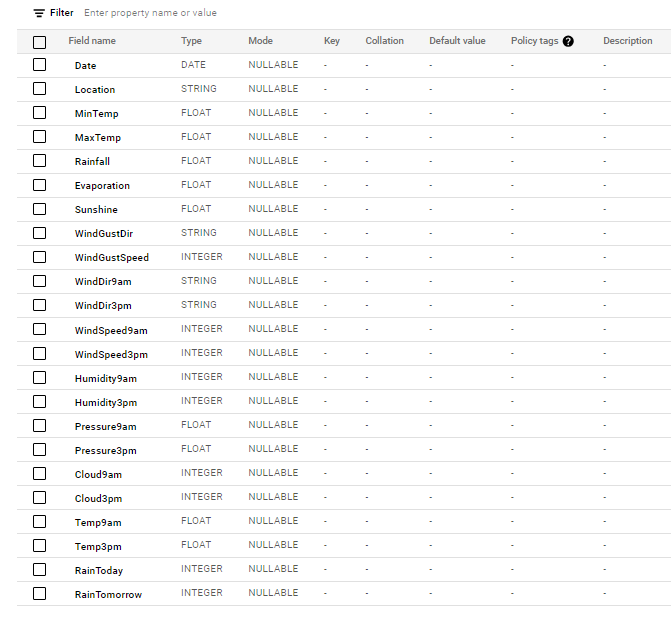

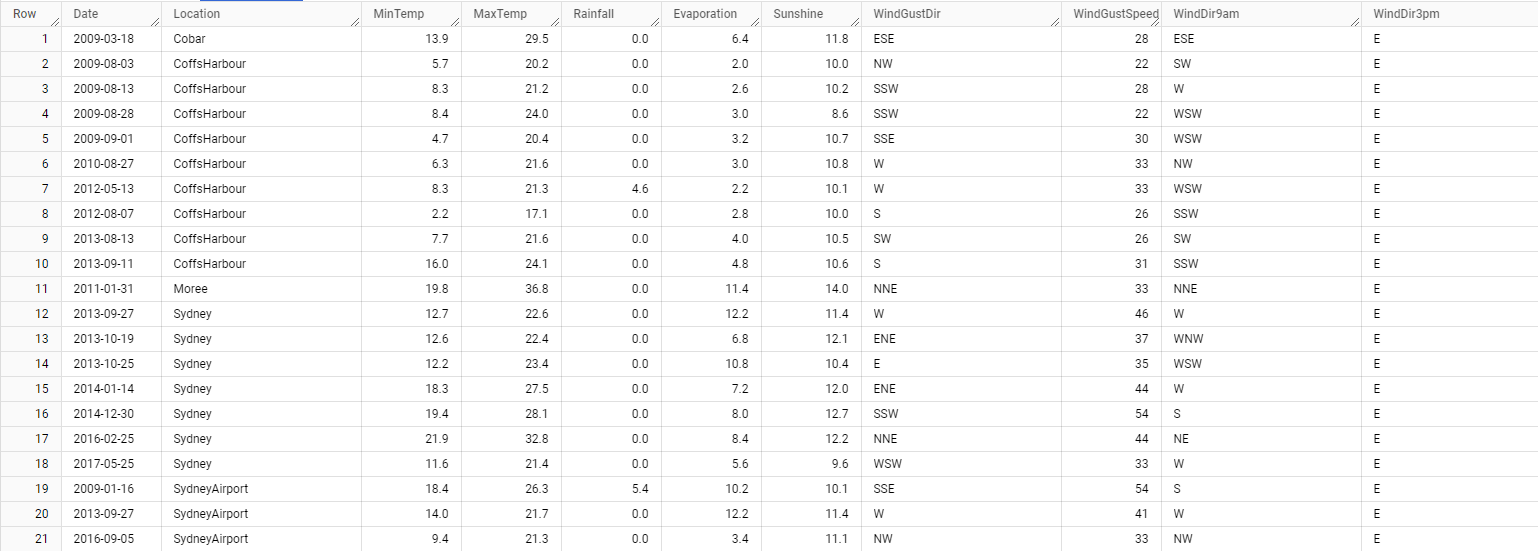

### Data Cleaning, Feature Engineering, and Exploration

Using Excel, NA and other blank values are filtered out and dropped. As some attributes e.g. wind direction or wind speed are not available at certain locations, the entire city's worth of data is dropped. However, with the vast amount of data (56420 entries in total post-cleaning), as well as the locality of the project (as different cities have varying climates, this project only focuses on the temperate climate of Southern Australia), the dropping of data of cities in other climates will be of little effect. 

After dropping of missing/non-numerical values, we turn to focus on one-hot encoding the categorical values, which appear in attributes such as wind direction. We pass the cleaned data set through the pandas library and use the get_dummies function:

In [2]:
import numpy as np
import pandas as pd

raw = pd.read_csv("weatherAUSclean.csv")

encoded = pd.get_dummies(raw, columns = ["WindDir9am" , "WindDir3pm"], dtype = int)

#encoded.to_csv("encoded.csv")

print(encoded.head(1))

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  01/01/2009    Cobar     17.9     35.2       0.0         12.0      12.3   

   WindSpeed9am  WindSpeed3pm  Humidity9am  ...  WindDir3pm_NW_B  \
0             6            20           20  ...                0   

   WindDir3pm_N_B  WindDir3pm_SE_B  WindDir3pm_SSE_B  WindDir3pm_SSW_B  \
0               0                0                 0                 0   

   WindDir3pm_SW_B  WindDir3pm_S_B  WindDir3pm_WNW_B  WindDir3pm_WSW_B  \
0                1               0                 0                 0   

   WindDir3pm_W_B  
0               0  

[1 rows x 51 columns]


We can see that following the one-hot encoding, all the unique values (the 16 cardinal directions) have their dedicated column, and are assigned values 0 and 1. With the data cleaned, it is now time to split the dataset into training and testing sets. However, as this is a binary classification project, it is important our training set has an equal split of positive (Rains tomorrow) and negative (Does not rain tomorrow) data for the model to not over-train on either result and lose the ability to make predictions for the other. We use Google's BigQuery SQL to count the number of "Yes Rain" and "No Rain" for each location:

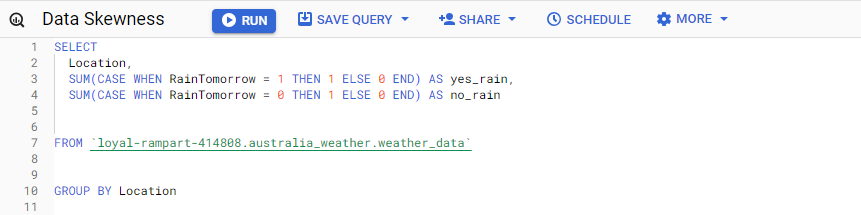

The data is saved as a .csv file and imported into Excel to calculate the percentage of "Yes Rain":

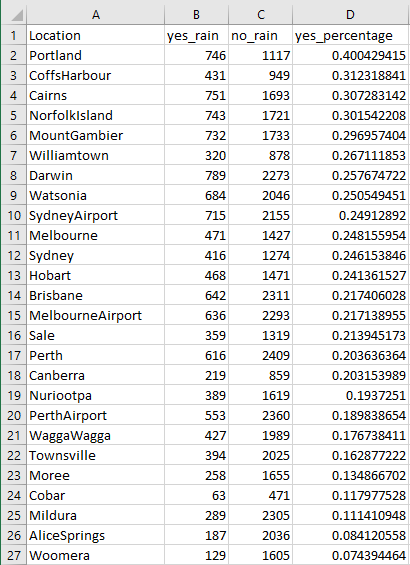

Plotting this information on as a histogram,

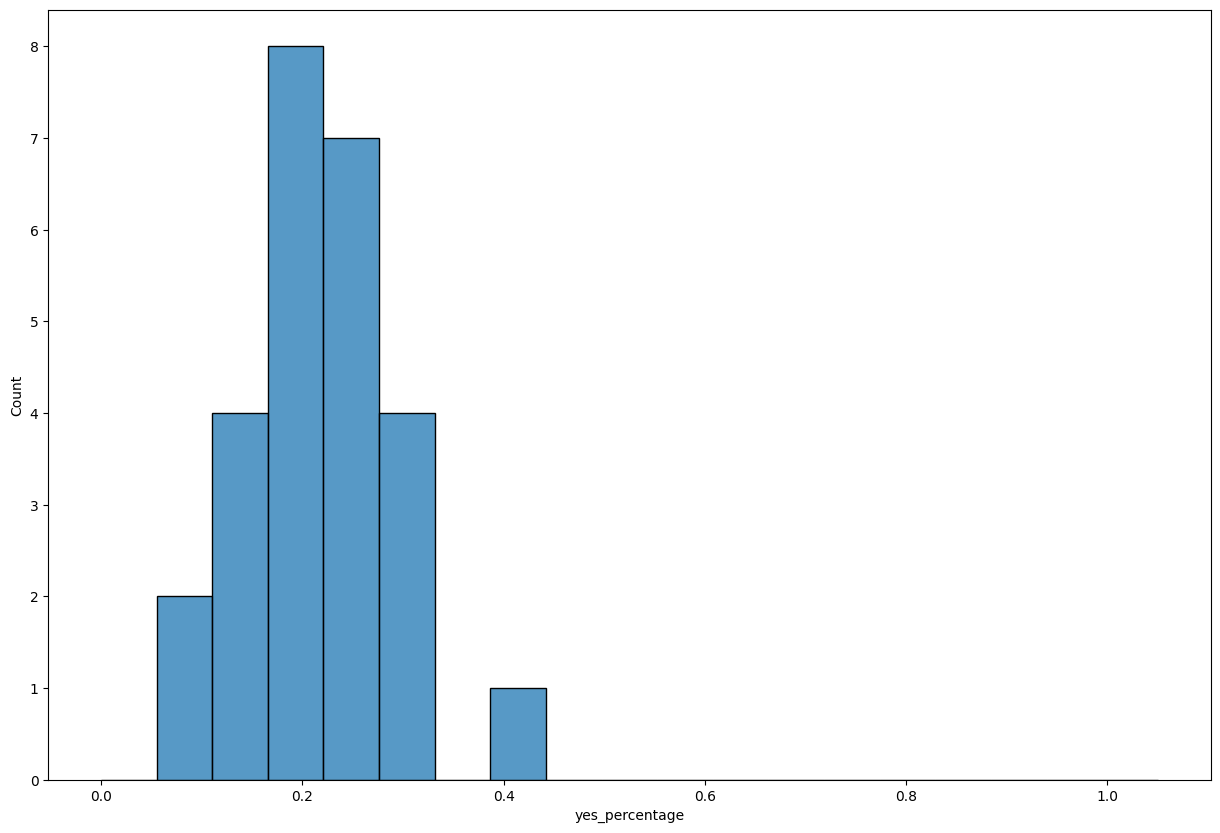

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 

raw = pd.read_csv(r"label_skew.csv")

n = 20

fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(ax = ax, data = raw, x = "yes_percentage", bins = np.linspace(0, 1 + 1/n, n))

plt.savefig(r"figs\data_skew.png")

We can see that much of the data is skewed towards the left, meaning that much of the data is deficient in "Yes Rain" instances, and so we have to be mindful when splitting our training data. 

From the .csv file, we see that the location with the largest portion of "Yes Rain" data is Portland, which resides in a temperate climate. Melbourne, another city in the temperate climate of South Australia, while doesn't have a particularly high "Yes Rain" ratio, the number of data entries of the "Yes Rain" type is numerous, so it would be good to include data from Melbourne as well for our training set. The final pool of training locations include: 

* Portland
* Melbourne Airport
* Melboune
* Watsonia
* Mount Gambier

### Data Splitting and Normalisation 

In this section, we create a python function which allows us to split the dataframe into the training and testing set. We need to create a custom function which selects a portion of the "Yes Rain" data, and select an equal number of "No Rain" data to ensure fair traiing opportunities of the model:

In [4]:
def DataSplitter(dataframe, n_yes, want_test):
    
    if n_yes == None:
        n_yes = int(len(dataframe[dataframe["RainTomorrow"] == 1]) * 0.9)
    else:
        pass

    yes_data = dataframe[dataframe["RainTomorrow"] == 1].sample(n = n_yes)
    no_data = dataframe[dataframe["RainTomorrow"] == 0].sample(n = n_yes)

    try:
        splitted_pool = pd.concat([yes_data, no_data], axis = 0).drop(columns = ['Unnamed: 0'])
    except KeyError:
        splitted_pool = pd.concat([yes_data, no_data], axis = 0)

    if want_test == True:
        try:
            test_pool = (dataframe.drop(labels = list(splitted_pool.index.values))).drop(columns = ['Unnamed: 0'])
        except KeyError:
            test_pool = dataframe.drop(labels = list(splitted_pool.index.values))
        

        return [splitted_pool, test_pool]
    else:
        return splitted_pool

In the above function, three parameters are taken in. 

1. **dataframe**: The `dataframe` parameter takes in the dataframe needed to be split.
2. **n_yes**: The `n_yes` parameter tells the function the number of "Yes Rain" and subsequently "No Rain" data used to form the training set. If no integer is passed to the argument, then it automatically takes 90% of the "Yes Rain" data and uses it as training data.
3. **want_test**: If set to `True`, the function returns the remainder of the `dataframe` not used as training data as test data.

With the data splitting function defined, we import the one-hot encoded, clean data .csv as a pandas dataframe:

In [5]:
data = pd.read_csv("encoded.csv")

loc = ["Portland", "MelbourneAirport", "Melbourne", "Watsonia", "Mount Gambier"]

location_data = data[data["Location"].isin(loc)]

train_pool, test_pool = DataSplitter(location_data, n_yes = None, want_test = True) #train pool now has equal split of yes/no rain

# Number of training data with "Yes Rain" / "No Rain"
print("Yes Rain Size:", len(train_pool[train_pool["RainTomorrow"] == 1]))
print("No Rain Size:", len(train_pool[train_pool["RainTomorrow"] == 0]))

feature_labels = (train_pool.drop(columns = ["Date", "Location", "RainTomorrow"])).columns

X_train = train_pool.drop(columns = ["Date", "Location", "RainTomorrow"])

Y_train = train_pool["RainTomorrow"]

Yes Rain Size: 2283
No Rain Size: 2283


We can see that now the training set has an equal balance of "Yes Rain" and "No Rain" data. The `DataSplitter` function has also returned the test dataframe, which will be further transformed later on.

In [5]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,SSW_B,SW_B,S_B,WNW_B,WSW_B,W_B,Spring,Summer,Autumn,Winter
count,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,...,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000
mean,10.308782,19.298182,2.497985,4.241524,5.585983,17.591546,21.154402,74.395532,59.068988,1016.389159,...,0.105563,0.090670,0.125055,0.049715,0.082348,0.080815,0.259089,0.199956,0.253176,0.287779
std,4.299058,6.242181,5.915478,3.204399,3.769308,10.555805,9.711638,16.513473,19.225242,8.153892,...,0.307311,0.287171,0.330817,0.217380,0.274924,0.272580,0.438182,0.400011,0.434878,0.452777
min,-1.200000,8.400000,0.000000,0.000000,0.000000,2.000000,2.000000,11.000000,6.000000,988.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.300000,14.600000,0.000000,2.000000,2.400000,9.000000,15.000000,64.000000,46.000000,1011.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.800000,17.600000,0.200000,3.400000,5.400000,15.000000,20.000000,75.000000,59.000000,1016.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.100000,22.600000,2.200000,5.800000,8.500000,24.000000,28.000000,87.000000,72.000000,1022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,28.800000,46.800000,84.000000,23.800000,13.800000,65.000000,76.000000,100.000000,100.000000,1038.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Using the `.describe()` method on the training set dataframe, we can see that the min/max and statistical structure of each feature is vastly different. In order to make training the model more efficient and easier, we must normalise all these columns. We use the `StandardScaler` function provided by scikit-learn. Once again, as the normalisation process will have to be applied later on again, we define a function which makes calling the normalising process easier:

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

def DataNormaliser(dataframe, normaliser):

    if normaliser == None:
        normaliser = make_column_transformer((
            StandardScaler(), ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
                            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
        ))

        normaliser.fit(dataframe)
    else:
        pass

    dataframe_norm = pd.DataFrame(data = normaliser.transform(dataframe))
    dataframe_onehot = dataframe.iloc[:, 15:]

    normalised_df = pd.concat([dataframe_norm.reset_index(drop = True), dataframe_onehot.reset_index(drop = True)], axis = 1)
    normalised_df.columns = dataframe.columns

    return [normaliser, normalised_df]

In the `DataNormaliser` function, two arguments must be passed:

1. **dataframe**: the dataframe to be normalised
2. **normaliser**: the normaliser to apply. If None is passed to `normaliser`, a new normaliser will be produced and fitted onto the passed `dataframe`. The new fitted normaliser object will then be returned along with the normalised dataframe

We create a normaliser object `normaliser` with the normalising method `StandardScaler()`, normalising the dataset using the z-value method. We pass the names of the features of the dataframe which needs normalising. Note that all one-hot encoded (categorical) features are not passed into the list, as they are already normaliser (only 0, 1 values). The normaliser is then fit to the dataframe (limited to the mentioned features). It is then concatenated with the remaining one-hot encoded features to reform the full normalised training data set.

Using the function to normalise the training data `X_train`:

In [7]:
adapted_normaliser, X_train_norm = DataNormaliser(X_train, normaliser = None)

X_train_norm.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,SSW_B,SW_B,S_B,WNW_B,WSW_B,W_B,Spring,Summer,Autumn,Winter
count,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,4.566000e+03,...,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000,4566.000000
mean,-2.396487e-16,5.975655e-16,-2.489856e-17,4.357248e-17,4.979713e-17,-1.493914e-16,1.742899e-16,2.987828e-16,4.979713e-17,3.709886e-15,...,0.107753,0.088042,0.125712,0.047744,0.080596,0.081472,0.257556,0.202584,0.252738,0.287122
std,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,...,0.310102,0.283387,0.331561,0.213248,0.272243,0.273588,0.437336,0.401969,0.434629,0.452469
min,-2.894508e+00,-1.747318e+00,-4.099871e-01,-1.307121e+00,-1.472932e+00,-1.486259e+00,-1.977848e+00,-3.800134e+00,-2.689815e+00,-3.327743e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.109210e-01,-7.670409e-01,-4.099871e-01,-7.567501e-01,-8.425755e-01,-8.143901e-01,-8.288446e-01,-6.159808e-01,-6.710509e-01,-6.533114e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.301797e-01,-2.610914e-01,-3.761837e-01,-2.675314e-01,-5.462933e-02,-2.385026e-01,-9.766050e-02,4.488114e-02,1.870549e-03,5.179437e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.363989e-01,5.452655e-01,-3.814918e-02,4.662966e-01,7.858466e-01,5.773378e-01,5.290687e-01,7.658215e-01,6.747920e-01,6.854577e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,4.678359e+00,4.324076e+00,1.378746e+01,5.970006e+00,2.177885e+00,4.560559e+00,4.602809e+00,1.546840e+00,2.124161e+00,2.859793e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that post-normalising, the training data is much more statistically consistent, with a mean of 0 and a standard deviation of 1 as expected. 

Now moving to the testing dataset, we split it into the feature frame and label frame as usual. We then normalise the feature frame using the already-fitted normaliser `adapted_normaliser` to be consistent with the training frame in order for model to be evaluated properly. 

In [8]:
X_test = test_pool.drop(columns = ["Date", "Location", "RainTomorrow"])
Y_test = test_pool["RainTomorrow"]

X_test_norm = DataNormaliser(X_test, adapted_normaliser)[1]

X_test_norm.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,SSW_B,SW_B,S_B,WNW_B,WSW_B,W_B,Spring,Summer,Autumn,Winter
count,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,...,4854.000000,4854.000000,4854.000000,4854.000000,4854.000000,4854.00000,4854.000000,4854.000000,4854.000000,4854.000000
mean,-0.021124,0.174696,-0.160904,0.065594,0.376117,-0.149403,-0.112035,-0.098854,-0.369504,0.360983,...,0.108570,0.086527,0.165019,0.028018,0.066543,0.05789,0.242068,0.264730,0.261640,0.231562
std,0.996587,1.000535,0.729594,0.977469,0.992921,0.976762,0.946093,0.965172,0.842601,0.905998,...,0.311131,0.281169,0.371236,0.165042,0.249255,0.23356,0.428380,0.441235,0.439573,0.421874
min,-2.755131,-1.652452,-0.409987,-1.307121,-1.472932,-1.486259,-1.977848,-3.800134,-2.741579,-3.402292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-0.710921,-0.608932,-0.409987,-0.695598,-0.396073,-0.814390,-0.828845,-0.736138,-0.929867,-0.230869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,-0.060491,-0.023928,-0.409987,-0.145227,0.470668,-0.430465,-0.202115,-0.075276,-0.360472,0.387263,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.682858,0.734997,-0.274773,0.588601,1.179820,0.241404,0.529069,0.585586,0.208923,0.958803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000
max,4.120847,4.308265,13.618444,5.664245,2.282944,4.752522,5.751812,1.546840,2.124161,2.847368,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


As the test dataframe is normalised using the normaliser fitted with the training data, it is expected that the mean and standard deviations are not 0 and 1 respectively. However, the variation in the data is reduced compared to the un-normalised version, which makes it ready for evaluation later on.

### Model Building and Training

We use a Sequential neural network provided by the keras library. We begin with a simple model of two hidden layers (excluding the output layer), each layer having 16 nodes. The activation function used for the hidden layers is the standard ReLU to account for non-linear relationships in the 50+ features in the training set. However, as we are dealing with a binary classification problem, the activation function for the output layer is set to be a sigmoid curve to constrain possible outputs in the range of 0 to 1. Binary Crossentropy is used as the loss function, and the keras optimiser Adam is used to compile the model. We choose Binary Accuracy as the metric to evaluate the model, and set the classification threshold to be 0.7. 

We fit the model using an initial learning rate of 0.01 for 50 epochs, as well as a validation set, which is 20% of the training data.

In [10]:
from tensorflow import keras
model = keras.models.Sequential(
    [ 
        keras.layers.Dense(units = 16, activation = "relu"),
        keras.layers.Dense(units = 16, activation = "relu"),
        keras.layers.Dense(units = 1, activation = "sigmoid")
    ]
)

metric = keras.metrics.BinaryAccuracy(threshold=0.7)
model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.01), metrics = metric)

history = model.fit(X_train_norm, Y_train, epochs = 50, verbose = 1, validation_split = 0.2)


Epoch 1/50

115/115 [==============================] - 2s 5ms/step - loss: 0.4828 - binary_accuracy: 0.7185 - val_loss: 0.7099 - val_binary_accuracy: 0.7746
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 0.4365 - binary_accuracy: 0.7525 - val_loss: 0.5545 - val_binary_accuracy: 0.8315
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 0.4224 - binary_accuracy: 0.7700 - val_loss: 0.6716 - val_binary_accuracy: 0.8293
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 0.4038 - binary_accuracy: 0.7807 - val_loss: 0.6250 - val_binary_accuracy: 0.8326
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 0.4028 - binary_accuracy: 0.7788 - val_loss: 0.7802 - val_binary_accuracy: 0.7812
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 0.3903 - binary_accuracy: 0.7903 - val_loss: 0.6667 - val_binary_accuracy: 0.8096
Epoch 7/50
115/115 [==============================] - 0s 3ms/s

Evaluating the model using the test set,

In [11]:
model.evaluate(X_test_norm, Y_test)

152/152 [==============================] - 0s 2ms/step - loss: 1.1488 - binary_accuracy: 0.7604


[1.1487643718719482, 0.7604038119316101]

We get a log loss of 1.149 and an accuracy of 0.76. We can pass the information from the `history` object to a pyplot plot and plot the evolution of the binary accuracy metric, loss, validation loss as the epoch increases. We can further probe the model and find relative weighting/importance each training feature has on the final prediction, using the `tf.GradientTape()` method.

<Axes: >

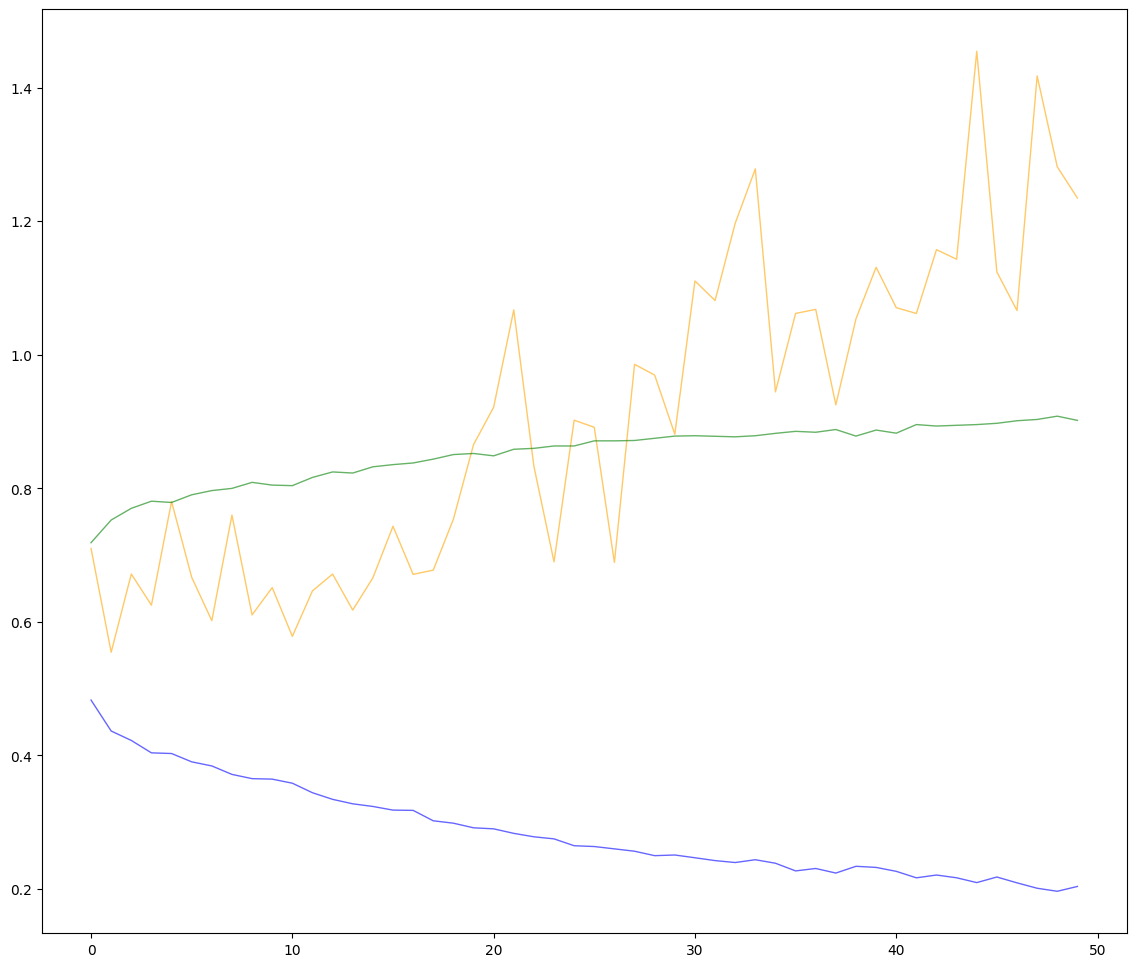

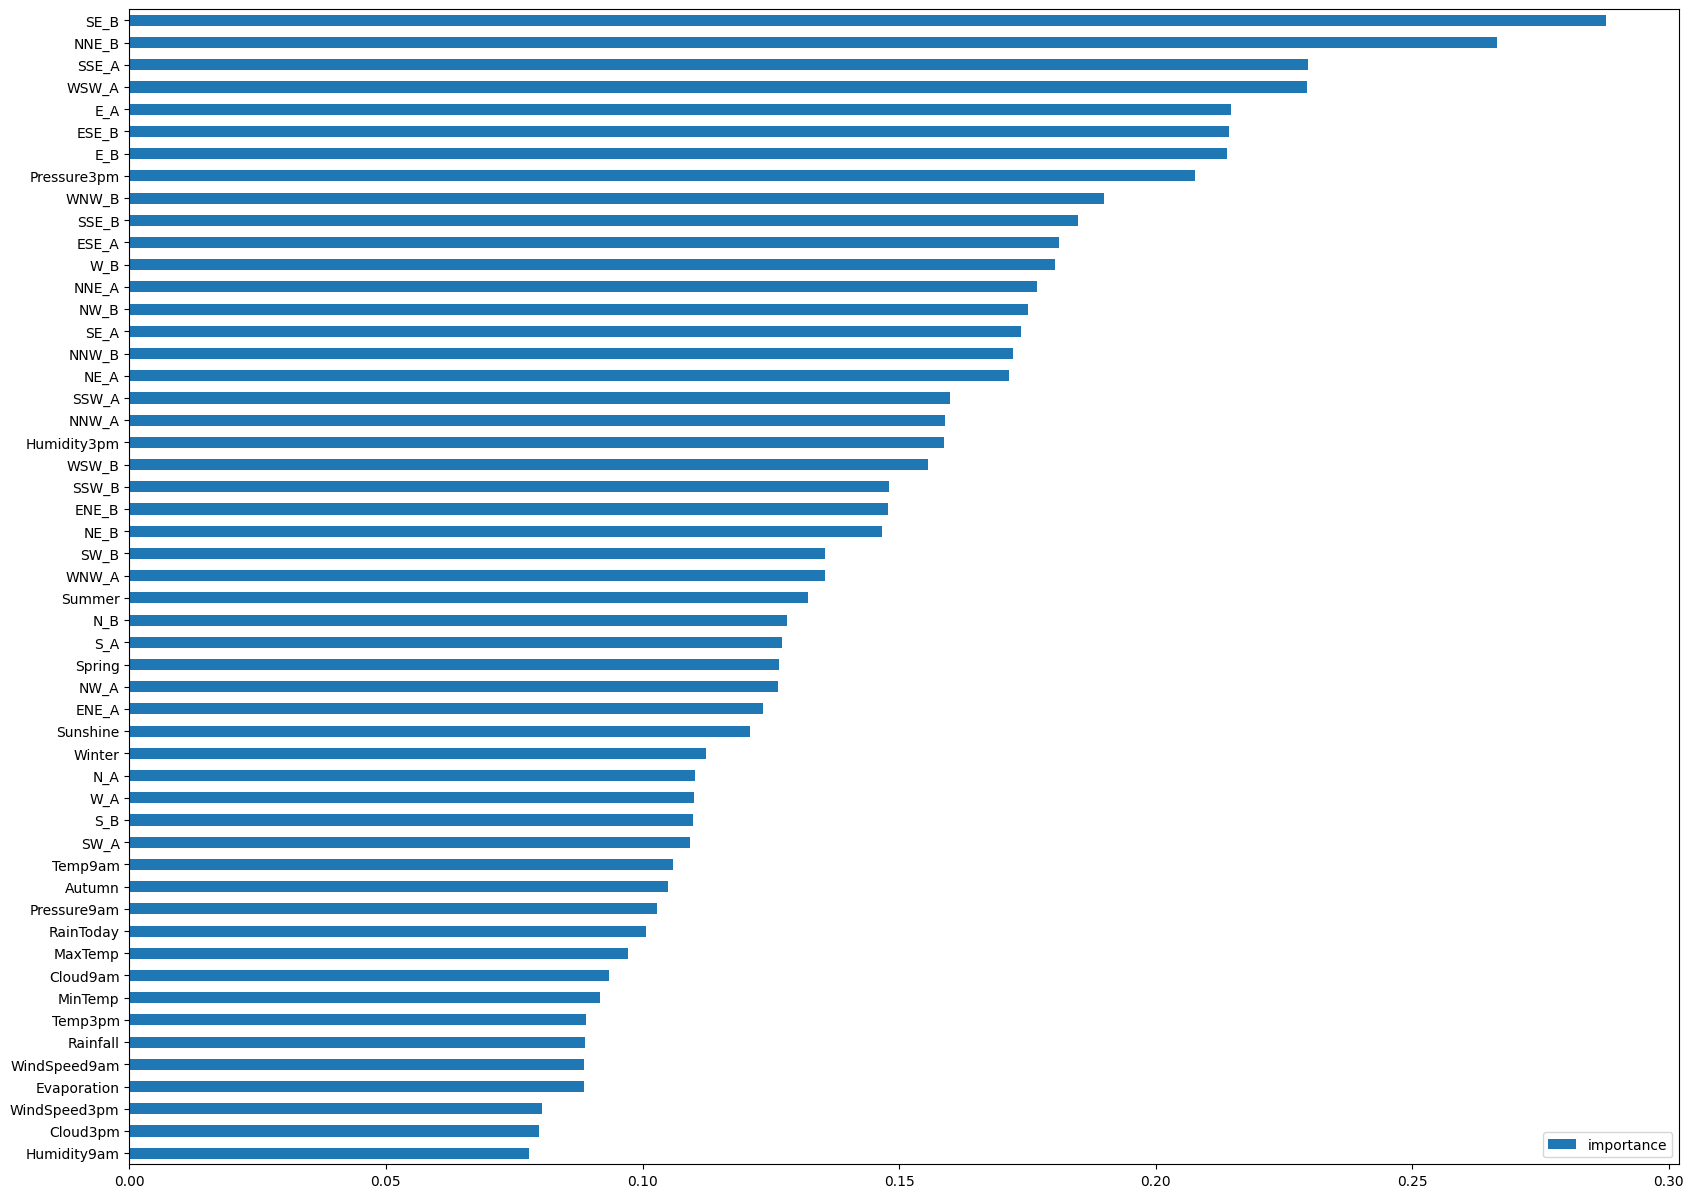

In [13]:
import tensorflow as tf

#plotting model metrics and losses
figL, axL = plt.subplots(figsize = (14, 12))

axL.plot(history.history["loss"], color = "blue", lw = 1, alpha = 0.6)
axL.plot(history.history["val_loss"], color = "orange", lw = 1, alpha = 0.6)
axL.plot(history.history["binary_accuracy"], color = "green", lw = 1, alpha = 0.6)

#plotting feature importance
input_tensor = tf.convert_to_tensor(X_train_norm)

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output = model(input_tensor)

gradients = tape.gradient(output, input_tensor)
feat_importance = np.mean(np.abs(gradients.numpy()), axis = 0)
   
figF, axF = plt.subplots(figsize = (20, 15))
feat_importance_arr = np.reshape(feat_importance, (len(feat_importance), 1))
feat_importance_df = pd.DataFrame(data = feat_importance_arr, columns = ["importance"], index = feature_labels).sort_values(by = ["importance"], ascending = True)
feat_importance_df.plot(kind = 'barh', ax = axF)

### Model Evaluation

From the graphs above, we can make two observations:

1. The validation loss (orange) diverges from the training loss (blue).
2. Many features contribute towards the final prediction

These two observations together suggest that it is possible that the model is overfitting the data. As a result, although the training loss is decreasing, the validation loss is increasing with epoch number, suggesting that the model is training too specifically and picking up all the noises and not generalising enough. Point 2 is also evidence for this, as all the different wind directions seem to play a part, which does not seem to be a realistic conclusion. 

However, as the model was tested on a random sample of the full dataset (the `.sample()` method is used in the `DataSplitter` function), it is better to evaluate the model multiple times on random samples of the full dataset to gain an averaged evaluation of the model before deciding on how to tweak the hyperparameters to increase the accuracy of the model and reduce its loss. We run a K-Fold cross-validation for k=30 times, and plot its loss-epoch function and its feature importance again.

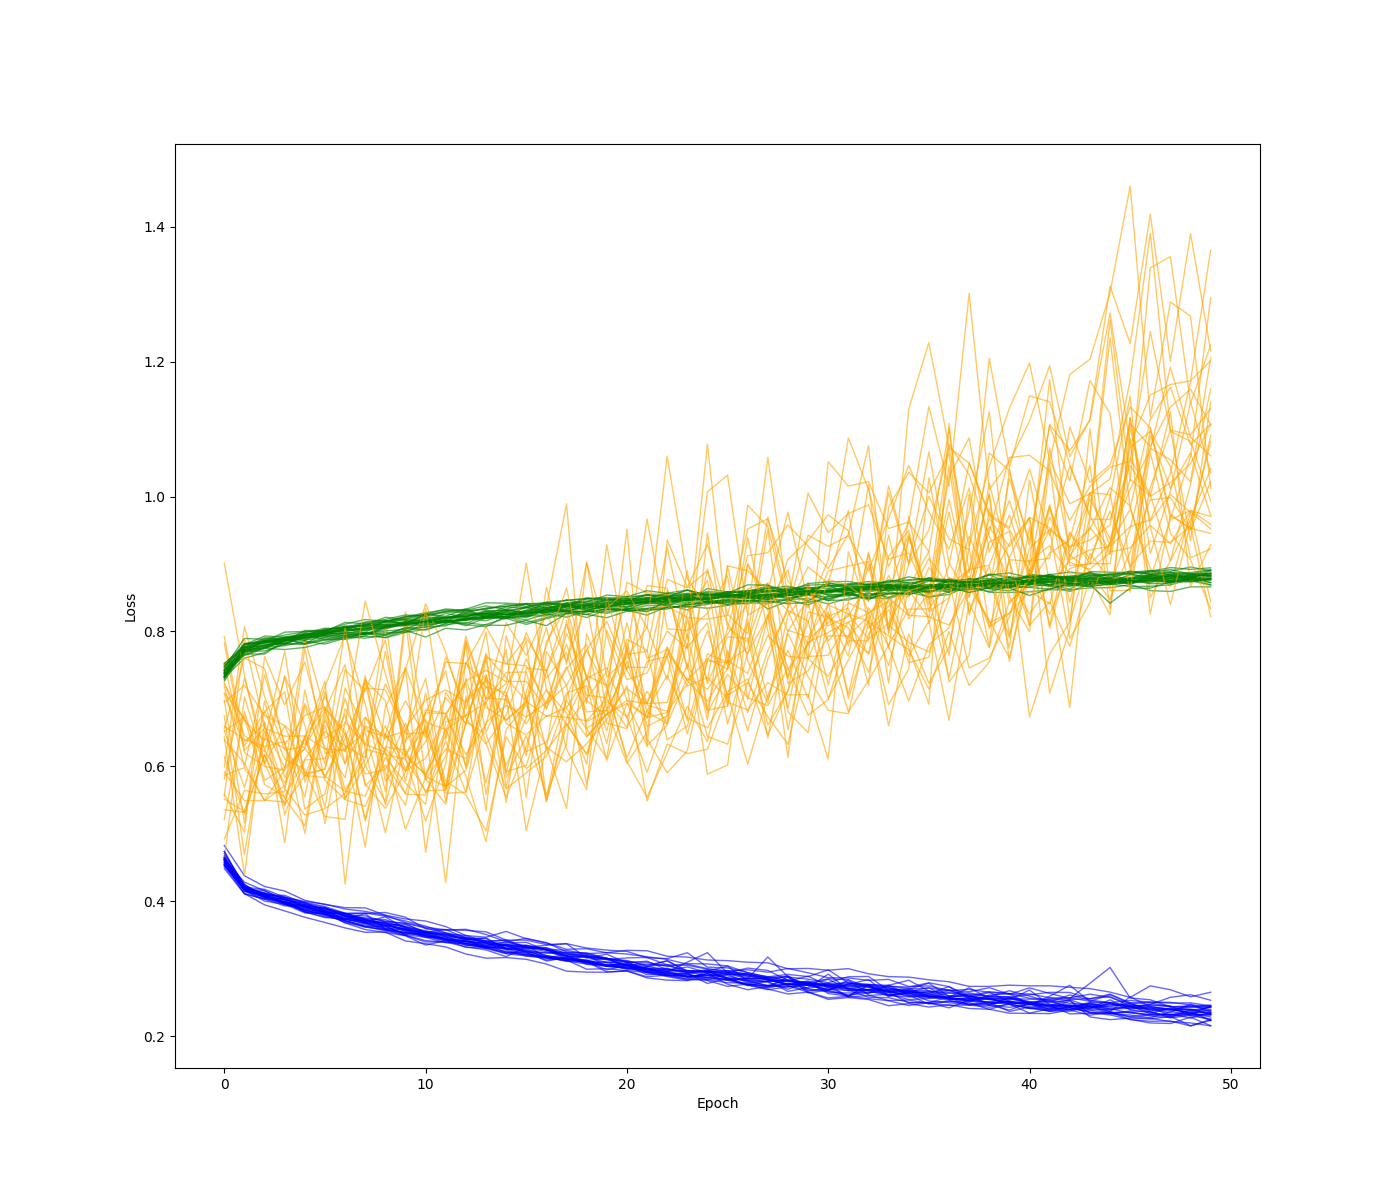
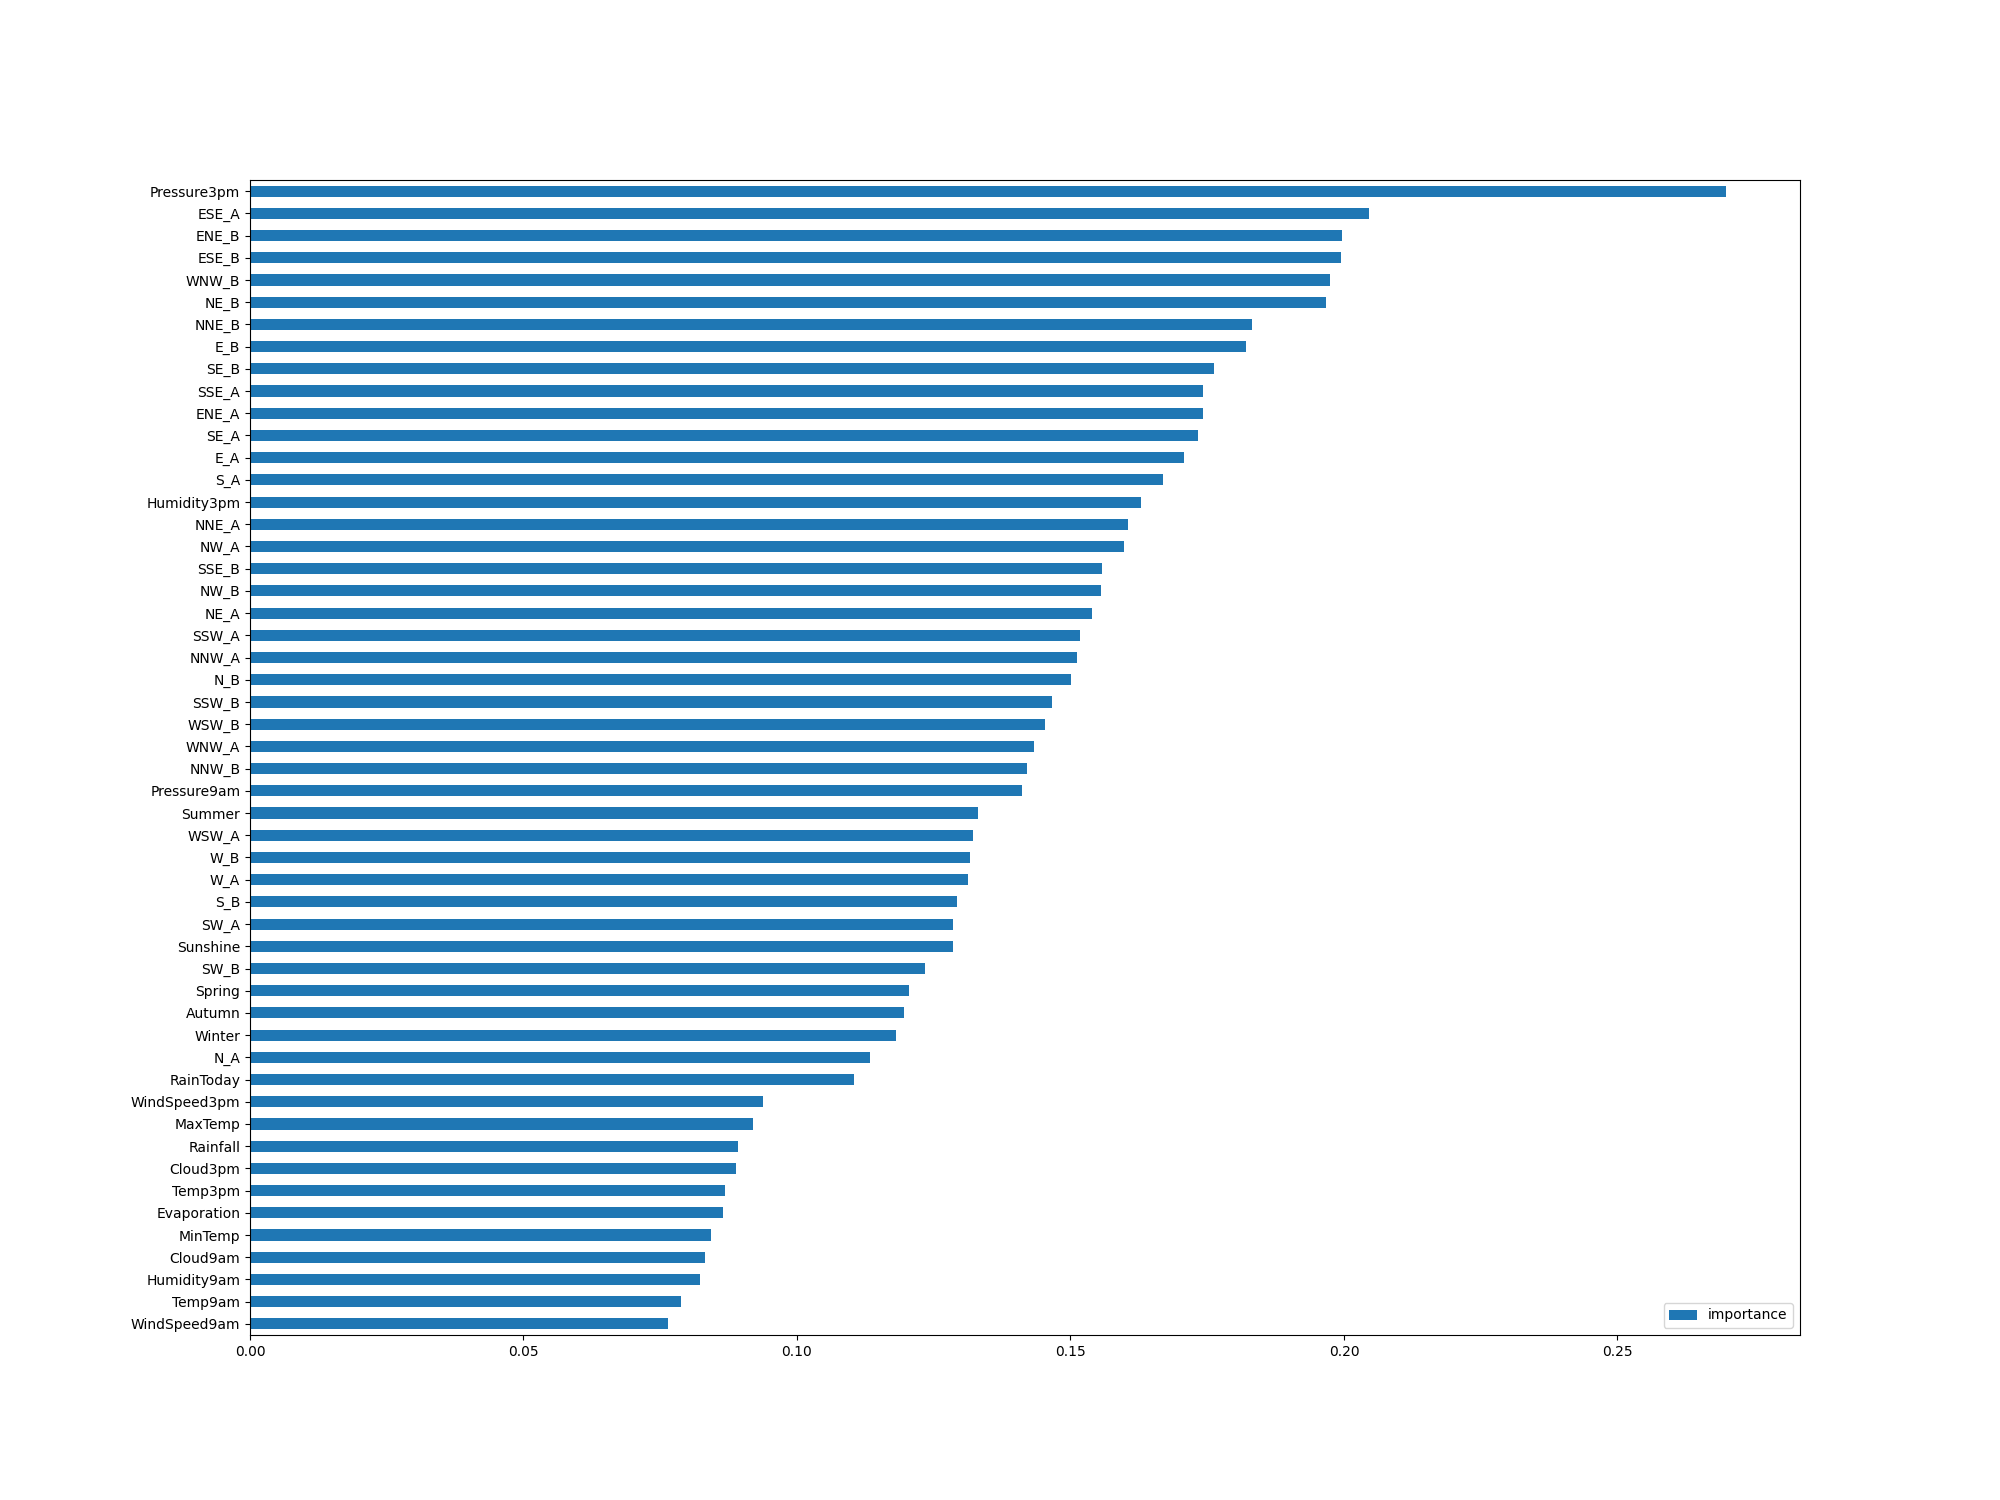

Once again, through these graphs, the 2 issues of diverging validation loss and odd feature importance are persistent, even after running a k=30 fold cross-validation. Hence, we can introduce some methods of bringing this loss-divergence down, and hone the model to more decisively pick out the key features. Here, we show the aggregate data for each fold's loss and accuracy evaluation:

In [14]:
aggregate = pd.read_csv(r"model data\base\model_eval.txt")
print(aggregate, "\n")
print("Mean loss:", aggregate["loss"].mean()) 
print("Mean accuracy:", aggregate["binary_accuracy"].mean()) 

        loss  binary_accuracy
0   0.884622         0.750208
1   1.282568         0.705882
2   1.083097         0.759373
3   0.982834         0.762706
4   0.964681         0.743376
5   0.993536         0.761206
6   1.198444         0.727379
7   1.146771         0.727045
8   0.918404         0.773704
9   1.138888         0.754708
10  0.979593         0.758040
11  1.071732         0.767039
12  1.051185         0.758707
13  1.059582         0.756541
14  0.902933         0.794368
15  0.818326         0.779370
16  1.168685         0.742210
17  0.903191         0.762540
18  0.949083         0.771538
19  1.375025         0.737377
20  0.965554         0.758540
21  0.883518         0.750042
22  1.142419         0.766206
23  1.054085         0.772538
24  1.083135         0.738377
25  0.892387         0.769872
26  1.001720         0.748542
27  1.115479         0.753874
28  1.047207         0.728212
29  1.113738         0.750208 

Mean loss: 1.0390807072321573
Mean accuracy: 0.7543242792288463


Next, we can try to improve this model. We can see that while training loss by epoch is low, validation loss by epoch is high, which suggests overfitting. First, we can reduce the learning rate to ensure that the training/validation losses are more stable instead of jittering as seen in the above figures. We select a small learning rate of 0.0002. 

Secondly, to prevent the domination of random features leading to overfitting of the training data, we introduce an L1 regularising scheme for the two hidden layers to encourage irrelevant or weak features to decrease. We use a regularisation parameter of 0.05 to make sure the regularising scheme is not so strong as to completely kill all feature effects. Compiling the new model and subjecting it to a k=30 fold cross validation again, we get

```
model = keras.models.Sequential(
    [ 
        keras.layers.Dense(units = 16, activation = "relu", kernel_regularizer=keras.regularizers.L1(0.05)),
        keras.layers.Dense(units = 16, activation = "relu", kernel_regularizer=keras.regularizers.L1(0.05)),
        keras.layers.Dense(units = 1, activation = "sigmoid")
    ]
)

thresh = 0.7

metrics = keras.metrics.BinaryAccuracy(threshold=thresh)

max_epoch, min_lr, max_lr, n = 100, 0.0002, 0.01, 4

def AdaptiveLearning(epoch): 
    if epoch == 0:
        return max_lr
    else:
        return (max_lr-min_lr)/(max_epoch**n)*(epoch-max_epoch)**n+min_lr

lr_scheduler = keras.callbacks.LearningRateScheduler(AdaptiveLearning)

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics = metrics)

history = model.fit(X_train_norm, Y_train, epochs = max_epoch, verbose = 1, validation_split = 0.2, callbacks = [lr_scheduler])

model.evaluate(X_test_norm, Y_test)

input_tensor = tf.convert_to_tensor(X_train_norm)

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output = model(input_tensor)

gradients = tape.gradient(output, input_tensor)
feat_importance = np.mean(np.abs(gradients.numpy()), axis = 0)
```
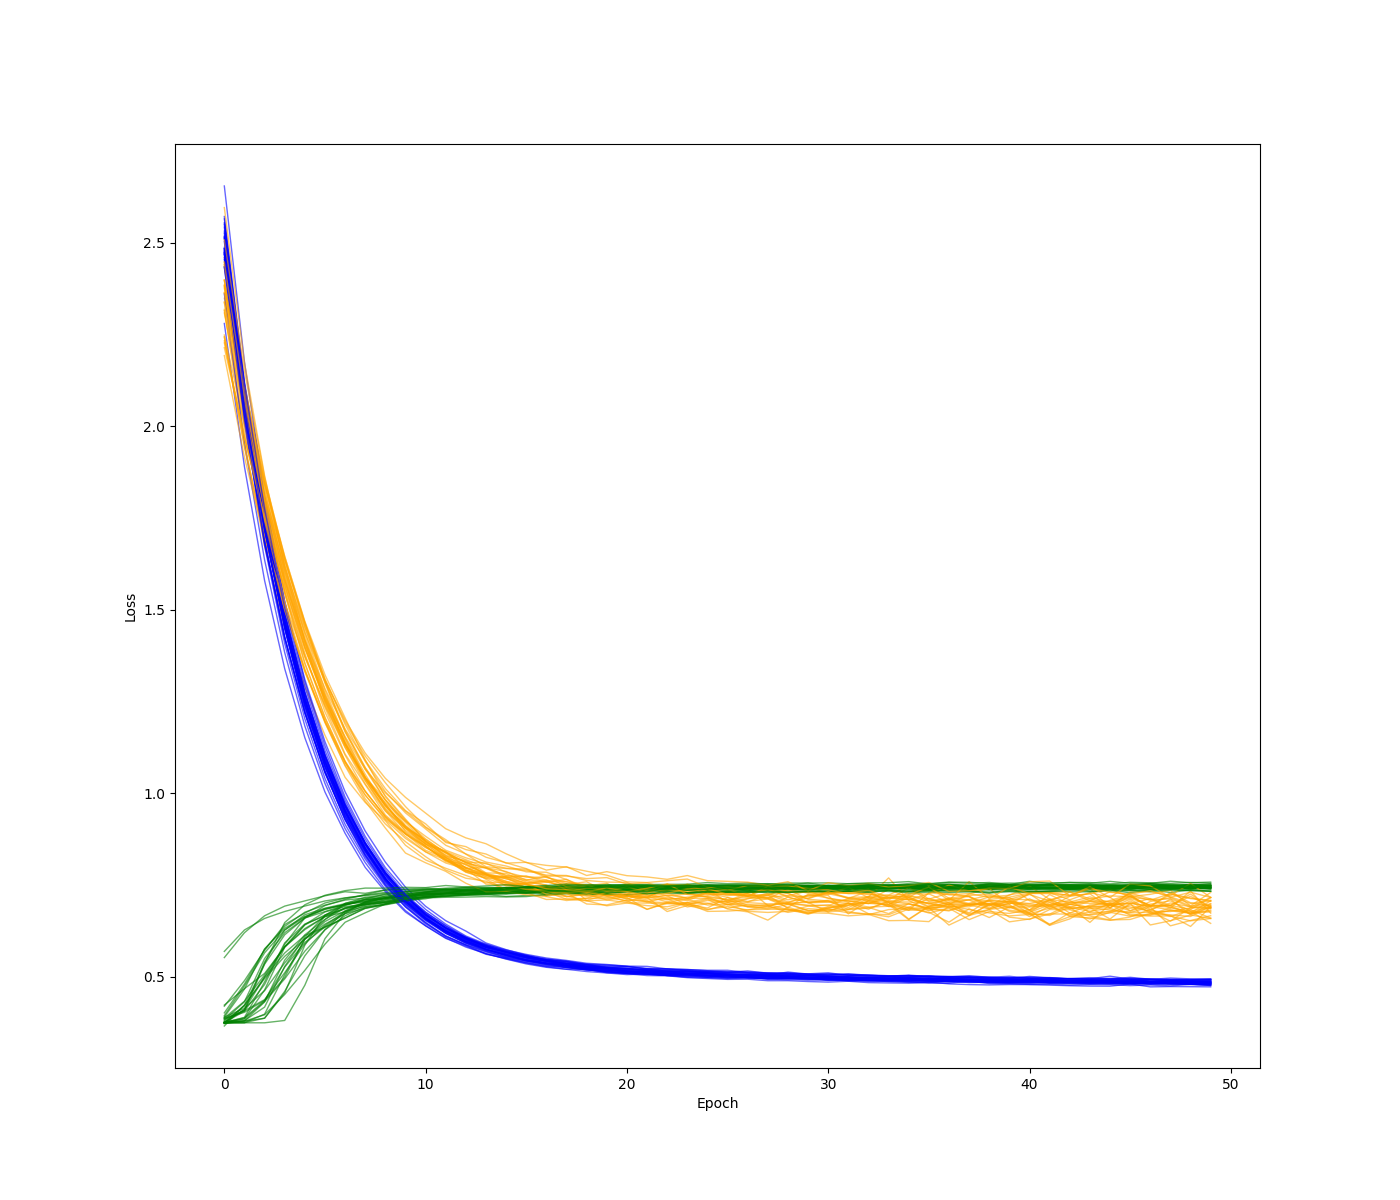
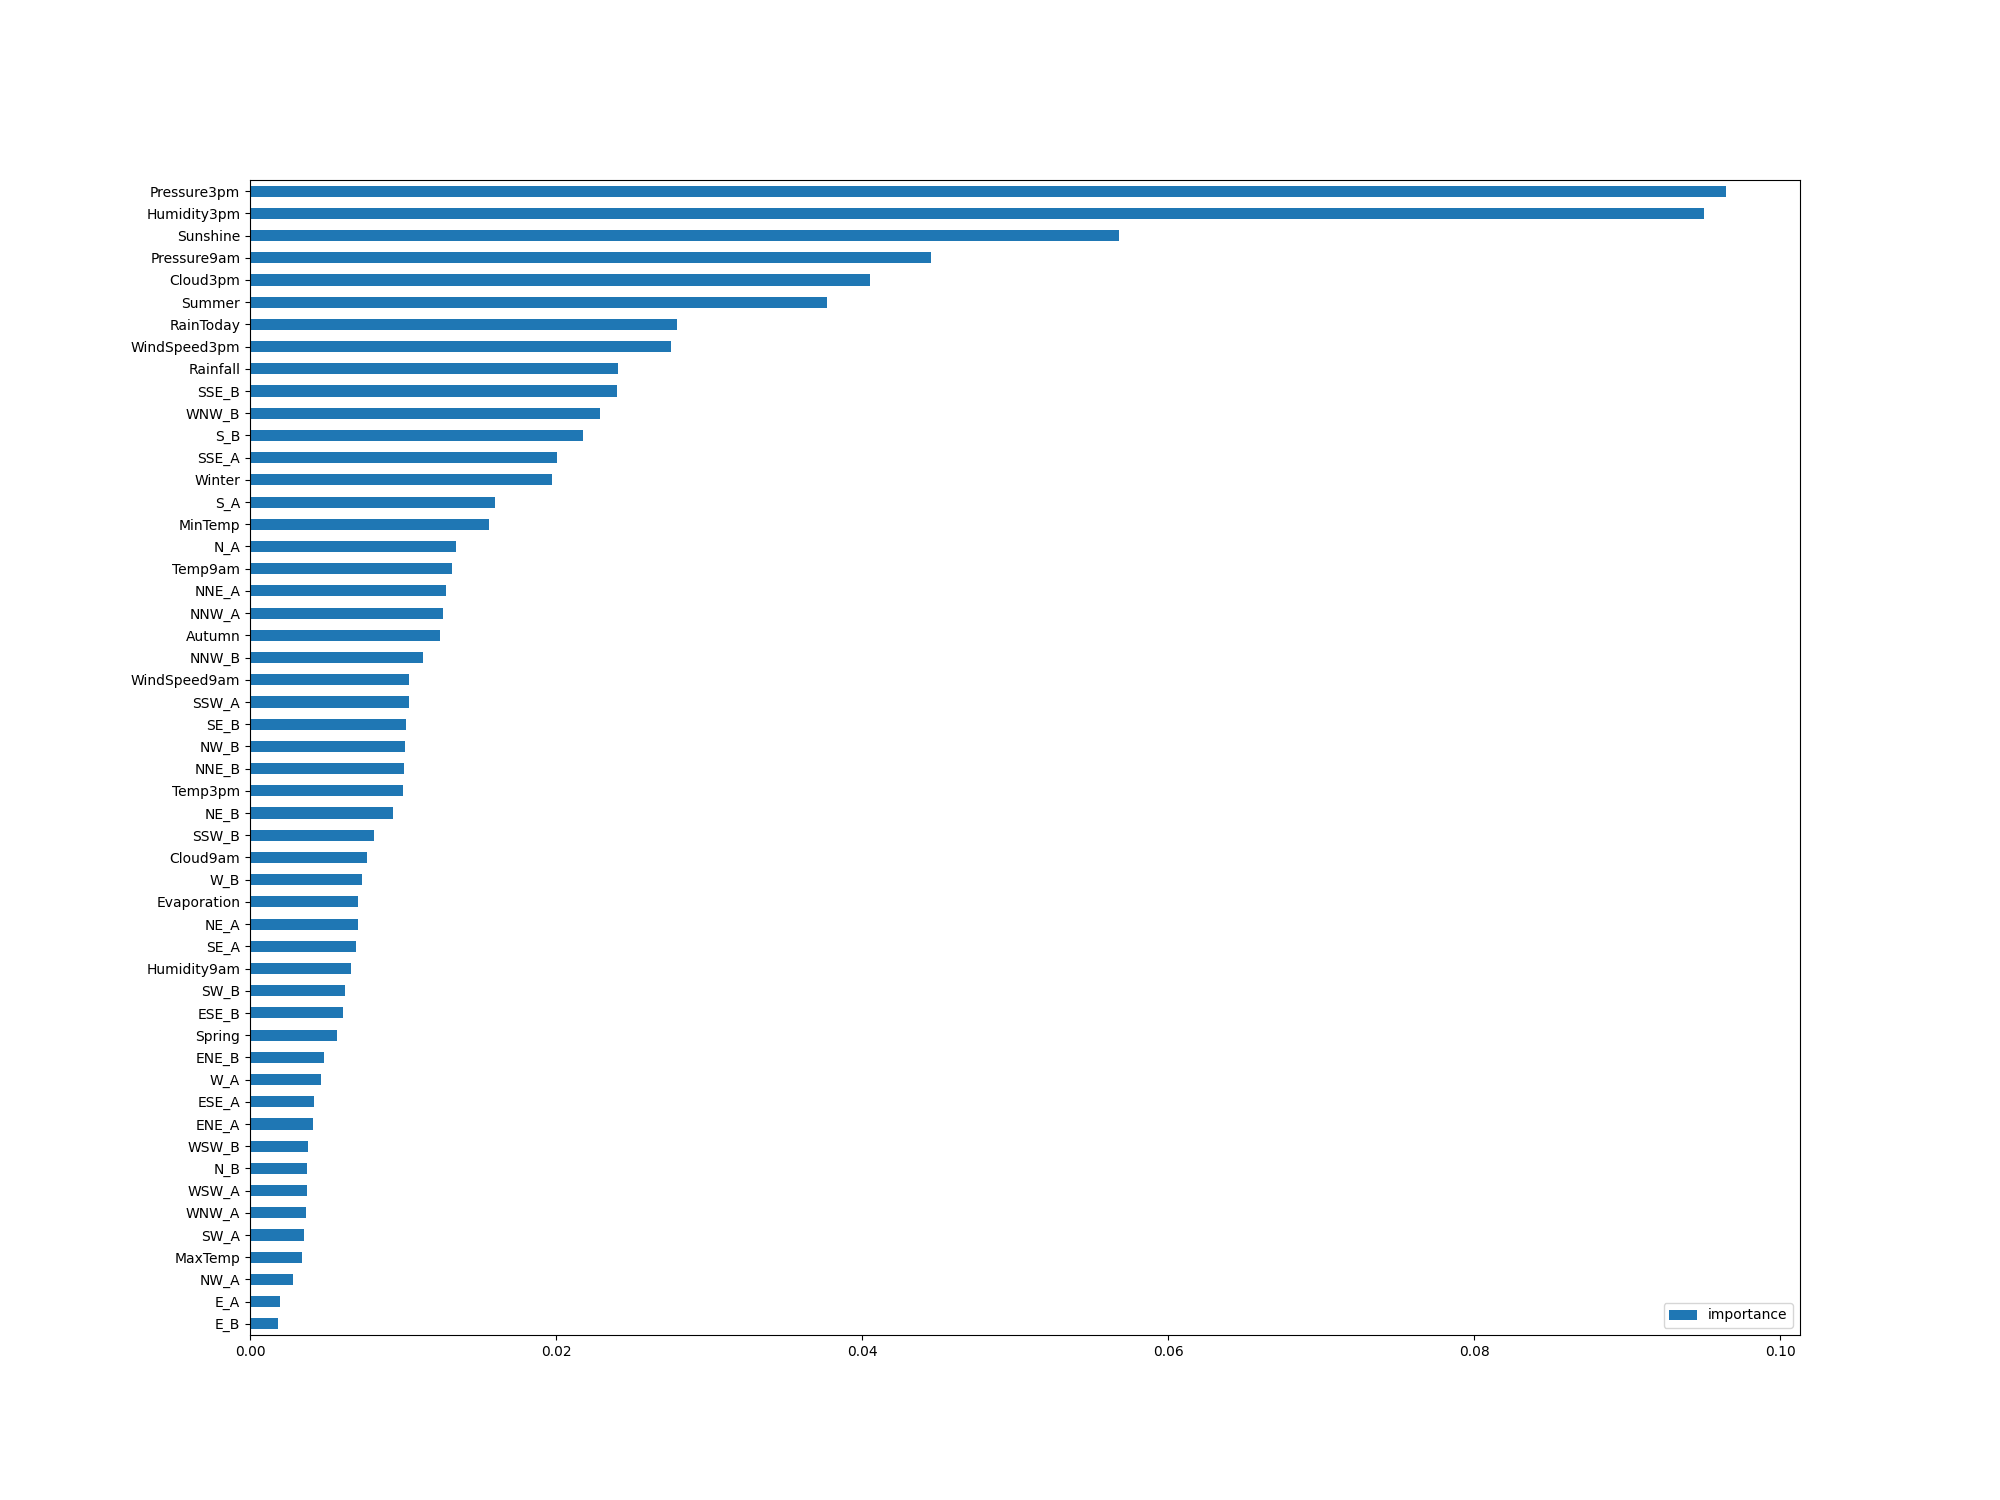

And the aggregate loss and accuracy data for this new model, 

In [15]:
aggregate = pd.read_csv(r"model data\regularised\model_eval.txt")
print(aggregate, "\n")
print("Mean loss:", aggregate["loss"].mean()) 
print("Mean accuracy:", aggregate["binary_accuracy"].mean()) 

        loss  binary_accuracy
0   0.678191         0.838694
1   0.665628         0.838860
2   0.672140         0.842193
3   0.665285         0.842526
4   0.661624         0.837194
5   0.660761         0.842193
6   0.668548         0.837194
7   0.673919         0.832028
8   0.664702         0.841193
9   0.669644         0.834528
10  0.640113         0.850525
11  0.680263         0.830028
12  0.680238         0.830528
13  0.683306         0.830362
14  0.681786         0.828029
15  0.667525         0.851025
16  0.686789         0.838860
17  0.660936         0.839693
18  0.659312         0.842360
19  0.719382         0.816697
20  0.682386         0.835527
21  0.674532         0.843693
22  0.664147         0.841193
23  0.698843         0.827362
24  0.681566         0.844526
25  0.657982         0.841860
26  0.689237         0.824696
27  0.666993         0.836361
28  0.675462         0.831528
29  0.669244         0.836861 

Mean loss: 0.6733495414257049
Mean accuracy: 0.8369438449541727


We can see that the loss is reduced significantly, and the mean accuracy increased.

### Result Analysis and Further Models

From the plotted graphs, we can see that firstly, reducing the learning rate has caused the fluctuation in training/validation loss to decrease, smoothing out the curves. Similarly, much of the features have a significantly lower contribution/importance to the final prediction. The top features are also quite interesting. 

1. Pressure at 3pm
2. Humidity at 3pm
3. Sunshine
4. Pressure at 9am
5. Cloud at 3pm

These features make the most sense in determining the probability of rain the next day. Taking pressure and humidity as an example, low atmospheric pressure can cause air from neighbouring areas to rush in, forcing the air to rise up and condense, forming clouds. High humidity increases the amount of water vapour that condenses, contributing to the likelihood of rain as well. If we take the two most prominent features, Pressure and Humidity at 3pm, and plot a classification scatter plot, we see that there is a significant overlap in the middle as expected, as these two are not the only features at play, so there will not be a clear linear division between the two clusters. However, towards the extremes, such as high humidity and low pressure, versus high pressure and low humidity, we see a clear domination by either classification as expected.

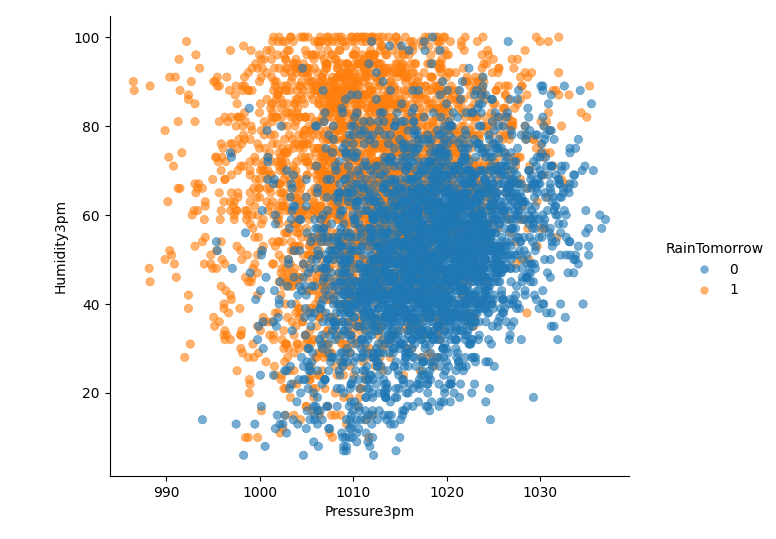

We can attempt to further separate/minimise the overlap by introducing a third dimension to the plot. We choose Sunshine as the third feature as it is the third most "important" feature. 

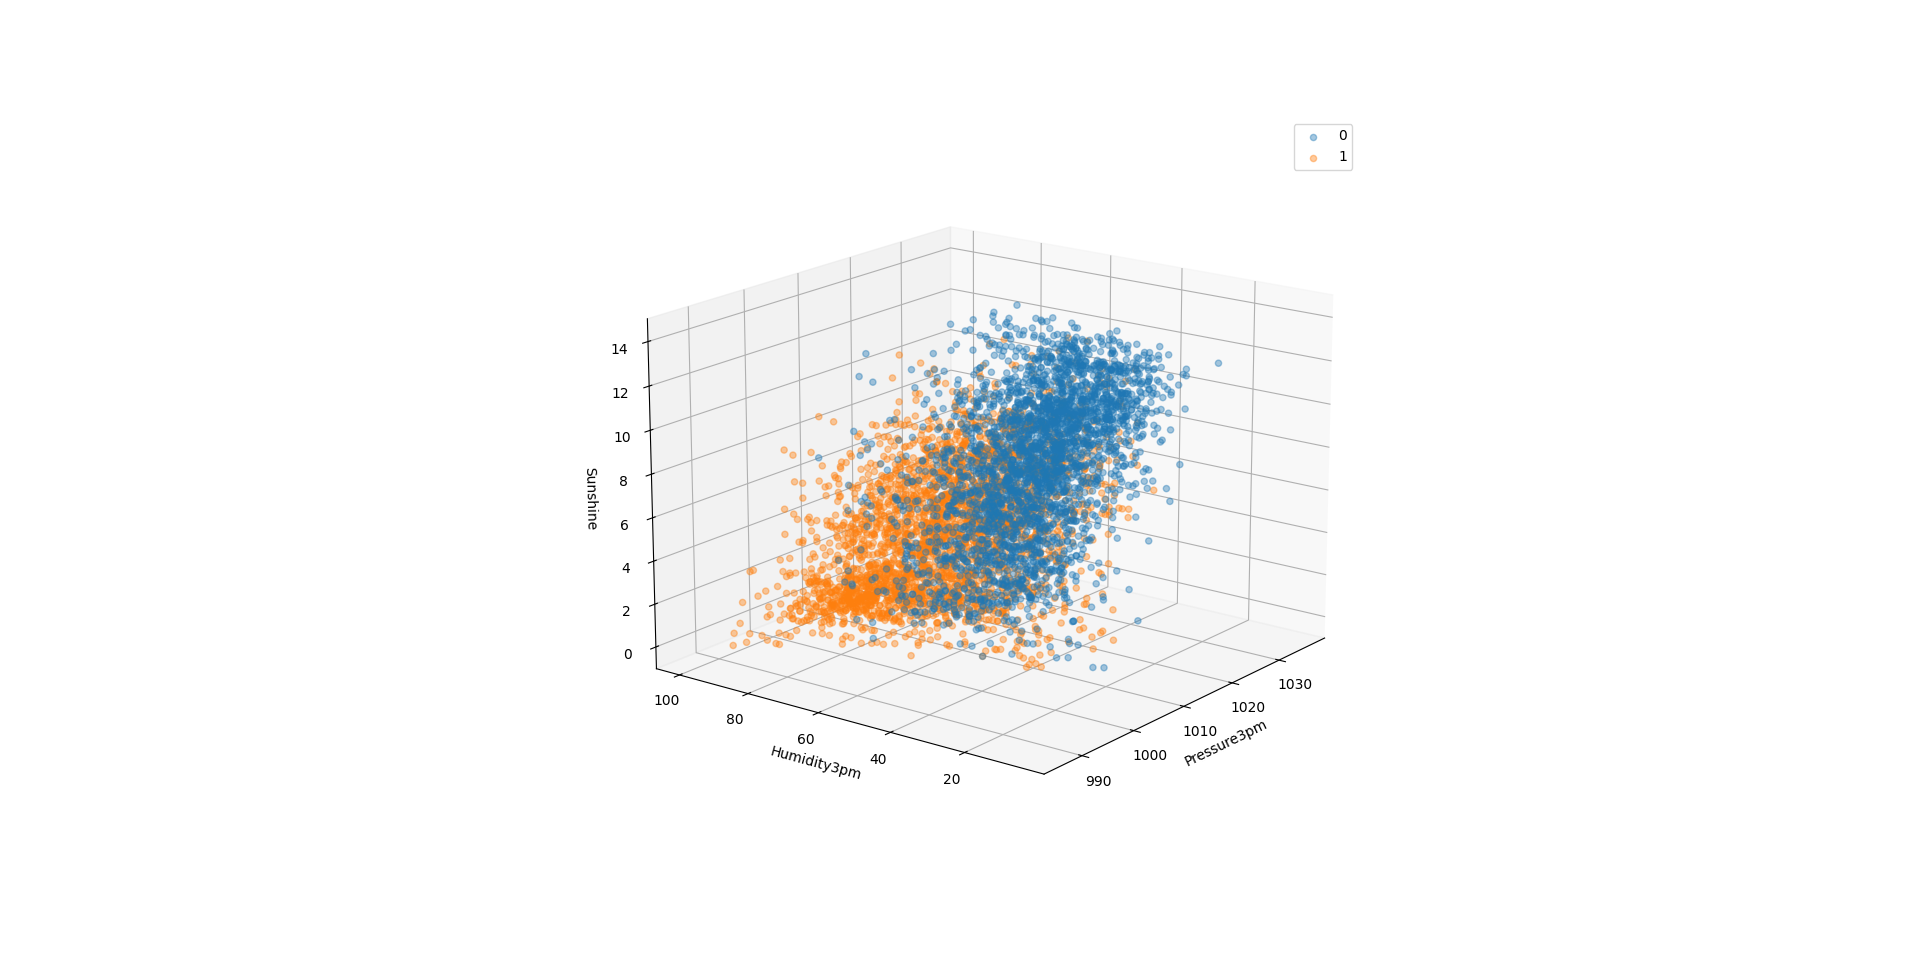

From this, we can see that the "Sunshine" feature skews the datapoints, with low sunshine increasing the likelihood of there being rain the next day, while more sunshine decreases the chance of rain. With the dataset narrowed down to three major features, we attempt to use other classification methods on these three features, namely K-Nearest Neighbours, Decision Tree, Random Forest, and Support Vector Machines through the scikit-learn library. We use the `GridSearchCV()` method to browse the optimum hyperparameters for each of the model, and pass them through a k=10 fold cross validation.  

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv("weatherAUSclean.csv")

export_dir = r"model data"

loc = ["MelbourneAirport", "Melbourne", "Watsonia", "Portland", "MountGambier"]

location_data = data[data["Location"].isin(loc)] #[["Pressure3pm", "Humidity3pm", "RainToday", "RainTomorrow"]]

train_pool, test_pool = DataSplitter(location_data, n_yes = None, want_test = True) #train pool now has equal split of yes/no rain

feature_labels = (train_pool.drop(columns = ["Date", "Location", "RainTomorrow"])).columns

X_train = train_pool.drop(columns = ["Date", "Location", "RainTomorrow"])

Y_train = train_pool["RainTomorrow"]

adapted_normaliser, X_train_norm = DataNormaliser(X_train, normaliser = None)

X_train_norm = X_train_norm[["Pressure3pm", "Humidity3pm", "RainToday"]]

#knn 

initK = int(np.sqrt(len(train_pool)))
n = 10
step = 10
K_cycle = np.concatenate((np.arange(initK-n*step, initK, step), np.arange(initK, initK+n*step, step)))
K_cycle = K_cycle[K_cycle > 0]

parameters = {'n_neighbors': list(K_cycle),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10, verbose = 2)
knn_cv.fit(X_train_norm, Y_train)
with open(export_dir + r"\model_mash.txt", "a+") as file:
    file.write("knn")
    file.write(f"{knn_cv.best_params_},{knn_cv.best_score_}\n")


#dec tree
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2']} 

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree,parameters,cv=10, error_score='raise', verbose = 2)
tree_cv.fit(X_train_norm, Y_train)
with open(export_dir + r"\model_mash.txt", "a+") as file:
    file.write("dectree")
    file.write(f"{tree_cv.best_params_},{tree_cv.best_score_}\n")

#svm
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1,10,500]
    }
svm = SVC()
svm_cv = GridSearchCV(svm,parameters,cv=10, verbose = 3)
svm_cv.fit(X_train_norm, Y_train)
with open(export_dir + r"\model_mash.txt", "a+") as file:
    file.write("svm")
    file.write(f"{svm_cv.best_params_},{svm_cv.best_score_}\n")

#random forest
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier()
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10, verbose = 2)
rfc_cv.fit(X_train_norm, Y_train)
with open(export_dir + r"\model_mash.txt", "a+") as file:
    file.write("randfor")
    file.write(f"{rfc_cv.best_params_},{rfc_cv.best_score_}\n")

In [17]:
acc_matrix = pd.read_csv("model data\model_mash.txt", sep = "/") 
print(acc_matrix[["model", "accuracy"]])

     model  accuracy
0      knn  0.736574
1  dectree  0.729438
2      svm  0.736915
3  randfor  0.738274


Summarising the accuracies for all the different models, we see that the model with the highest out-of-sample accuracy is the regularised neural network, with a binary accuracy of 83.7%. 

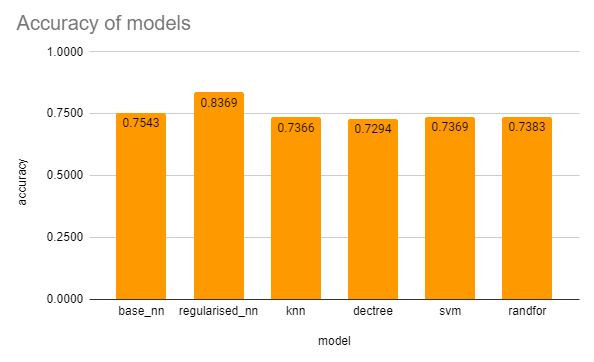